In [21]:
import numpy as np
import pylab
import pandas as pd


In [5]:
n_iter = 50
sz = (n_iter,)
x = -0.37727
xhat=numpy.zeros(sz)      # a posteri estimate of x
P=numpy.zeros(sz)         # a posteri error estimate
xhatminus=numpy.zeros(sz) # a priori estimate of x
Pminus=numpy.zeros(sz)    # a priori error estimate
K=numpy.zeros(sz) 
R = 0.1**2 

xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]  #X(k|k-1) = AX(k-1|k-1) + BU(k) + W(k),A=1,BU(k) = 0
    Pminus[k] = P[k-1]+Q  
    K[k] = Pminus[k]/( Pminus[k]+R ) #Kg(k)=P(k|k-1)H'/[HP(k|k-1)H' + R],H=1
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k]) #X(k|k) = X(k|k-1) + Kg(k)[Z(k) - HX(k|k-1)], H=1
    P[k] = (1-K[k])*Pminus[k] #P(k|k) = (1 - Kg(k)H)P(k|k-1), H=1


Text(0, 0.5, 'Voltage')

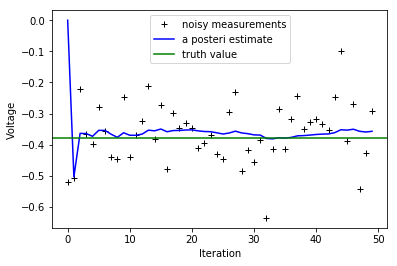

In [6]:

pylab.figure()
pylab.plot(z,'k+',label='noisy measurements')     #测量值
pylab.plot(xhat,'b-',label='a posteri estimate')  #过滤后的值
pylab.axhline(x,color='g',label='truth value')    #系统值
pylab.legend()
pylab.xlabel('Iteration')
pylab.ylabel('Voltage')



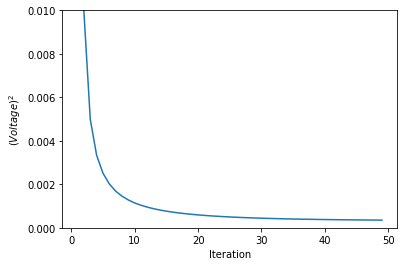

In [7]:

pylab.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
pylab.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
pylab.xlabel('Iteration')
pylab.ylabel('$(Voltage)^2$')
pylab.setp(pylab.gca(),'ylim',[0,.01])
pylab.show()

# part2 stock 

In [ ]:
import tushare as ts
df1 = ts.get_hist_data('399001') 
df2 = ts.get_hist_data('399006') 
df = {'深指':df1['close'],'创指':df2['close']}
df = pd.DataFrame(df)
df=df.dropna()
df.index = pd.to_datetime(df.index)



In [ ]:
# 创指 = alpha + beta * 深指 + 随机误差 
from pykalman import KalmanFilter
#建立观测矩阵
observation_matrices = np.vstack(( np.ones(len(df['2016':])),
                                  df.loc['2016':,'深指'].values )).T
Shape = observation_matrices.shape
observation_matrices = observation_matrices.reshape(Shape[0],1,Shape[1])
observation_matrices.shape


In [114]:
kf = KalmanFilter(transition_matrices=np.array([[1,0],[0,1]]), #转移矩阵为单位阵
                  observation_matrices=observation_matrices)
kf 
np.random.seed(0)
kf.em(df.loc['2016':,'创指'])
filter_mean,filter_cov = kf.filter(df.loc['2016':,'创指'])
df3 = df.loc['2016':,'创指']
filter_mean
# df['深指'].values[start_index]

array([[-0.08231272,  0.1927994 ],
       [-0.08260186,  0.19285662],
       [-0.07818906,  0.19213356],
       [-0.08036445,  0.19243042],
       [-0.08326236,  0.19290224],
       [-0.08213183,  0.19261527],
       [-0.08351834,  0.19271945],
       [-0.08646355,  0.19311933],
       [-0.08668061,  0.19348841],
       [-0.07787562,  0.19260318],
       [-0.08694402,  0.19334067],
       [-0.08862092,  0.19266573],
       [-0.0861416 ,  0.19185727],
       [-0.09156344,  0.19212671],
       [-0.09286129,  0.19261063],
       [-0.25730744,  0.19462887],
       [-0.27246928,  0.19560106],
       [-0.29297701,  0.19668785],
       [-0.29273805,  0.19689976],
       [-0.31589749,  0.19880959],
       [-0.23131677,  0.19645903],
       [-0.24733004,  0.19679986],
       [-0.24592755,  0.1982504 ],
       [-0.20167815,  0.19581507],
       [-0.19938773,  0.19570729],
       [-0.20406363,  0.196409  ],
       [-0.20597978,  0.19575097],
       [-0.22942615,  0.19736104],
       [-0.24373312,

In [119]:
for i in range(293,len(df)):
    observation_matrix = np.array([[1,df['深指'].values[i]]])
    observation = df['创指'].values[i]
    next_filter_mean,next_filter_cov = kf.filter_update(
            filtered_state_mean = filter_mean[-1],
            filtered_state_covariance = filter_cov[-1],
            observation = observation,
            observation_matrix = observation_matrix)
    filter_mean = np.vstack((filter_mean,next_filter_mean))
    filter_cov = np.vstack((filter_cov,next_filter_cov.reshape(1,2,2)))
filter_mean

masked_array(
  data=[[-8.23127211e-02,  1.92799396e-01],
        [-8.26018602e-02,  1.92856624e-01],
        [-7.81890645e-02,  1.92133563e-01],
        ...,
        [-2.26954727e+02,  2.23323789e-01],
        [-2.26864321e+02,  2.22915656e-01],
        [-2.26999993e+02,  2.23260535e-01]],
  mask=False,
  fill_value=1e+20)

In [120]:
filter_mean[293:,0]
alpha = pd.Series(filter_mean[293:,0], index = df.index[293:])
beta = pd.Series(filter_mean[293:,1], index = df.index[293:])

ValueError: Length of passed values is 711, index implies 319